In [1]:
import os
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np

In [58]:
os.makedirs('./data',exist_ok=True)
os.makedirs('./CGAN_image',exist_ok=True)
os.makedirs('./DCCGAN_image',exist_ok=True)
os.makedirs('./WCGAN_image',exist_ok=True)

#### image preprocess

In [3]:
image_size = 32
# image preprocess (no image augmentation)
transform = transforms.Compose([transforms.Resize([image_size,image_size]),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST('data/', download = True, train = True, transform = transform)
testset = torchvision.datasets.FashionMNIST('data/', download = True, train = False, transform = transform)
dataset = ConcatDataset([trainset, testset])
print(f'Total {len(dataset)} data')

Total 70000 data


In [4]:
bs = 128 # batch size
dataloader = DataLoader(dataset, batch_size = bs, shuffle = True) # to torch dataloader

In [5]:
# show data shape
dataiter = iter(dataloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([128, 1, 32, 32])
torch.Size([128])


In [155]:
# collect some real images  for each label
labels = [i for i in range(10)]
image_dict = {label:[] for label in labels}
for img, label in dataset:
    if sum([len(v) for v in image_dict.values()]) != 100: #  100 images per label
        if len(image_dict[label]) != 10:
            image_dict[label].append(img)
        else:
            continue
    else:
        break
    
images = [torch.stack(image_dict[i]) for i in image_dict.keys()]
images = torch.cat(images)

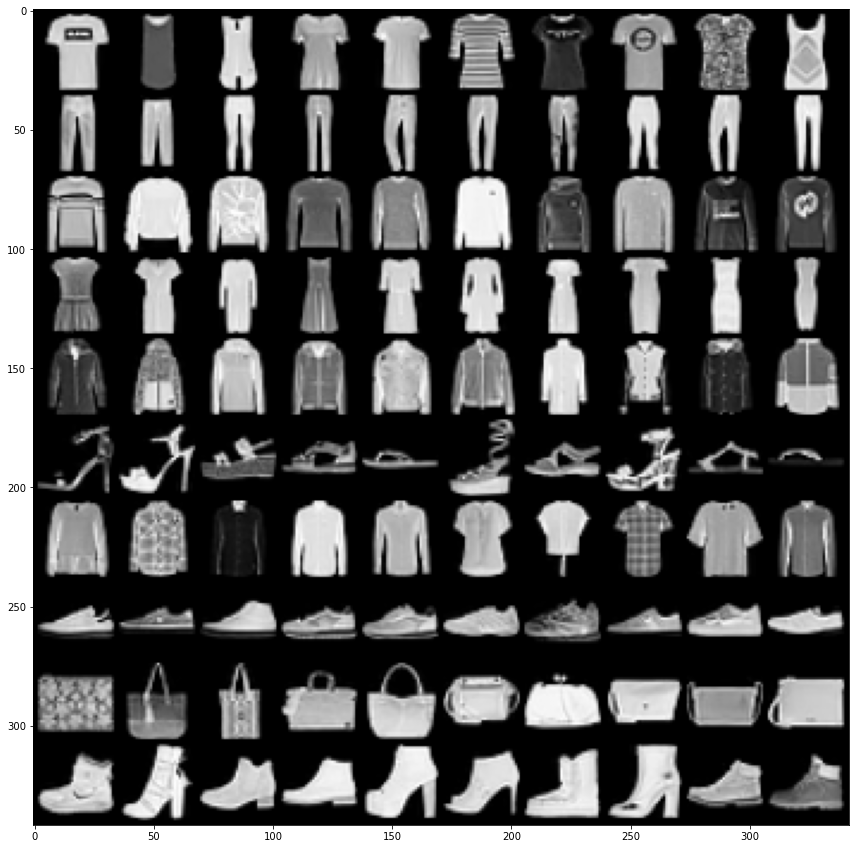

In [156]:
#show some samples
images = images*0.5 + 0.5 
grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

#### Model Setting

##### DCCGAN & WCGAN

In [141]:
# All model weights will be initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes):
        super(Generator, self).__init__()
        self.image = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 64 * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU()
        )
        self.label = nn.Sequential(
            nn.ConvTranspose2d(num_classes, 64 * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU()
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64*2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

        self.apply(weights_init)

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.image = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.label = nn.Sequential(
            nn.Conv2d(num_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.main = nn.Sequential(
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid() # for DCGAN (WGAN is linear output)
        )
        self.apply(weights_init)

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

##### CGAN

In [53]:
# CGAN (no convolution layer)
class GeneratorModel(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(GeneratorModel, self).__init__()
        input_dim = z_dim + num_classes
        output_dim = img_size**2
        self.label_embedding = nn.Embedding(10, 10)
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
        self.apply(weights_init)
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output
        
class DiscriminatorModel(nn.Module):
    def __init__(self, num_classes, img_size):
        super(DiscriminatorModel, self).__init__()
        input_dim = img_size**2 + num_classes
        output_dim = 1
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )
        self.apply(weights_init)

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output

#### Training Model
There are different combination codes for DCCGAN and CGAN and WCGAN structural models, where the code with a common dashed line will declare the use of that code, and the other codes (wihtout common) are used for the WCGAN model.

In [142]:
# Training hyperparameters:
z_dim = 120
lr = 0.0002 #0.0005


n_epoch = 85
n_critic = 1 # 5
model_path = './model'
classes = 10

# --------CGAN----------
# z_sample = Variable(torch.randn(100, z_dim)).cuda()
# ----------------------
z_sample = Variable(torch.randn(100, z_dim, 1, 1)).cuda()

one_hot_label = torch.zeros(classes, classes)
for i in range(len(one_hot_label)):
    one_hot_label[i][i] = 1
one_hot_label = one_hot_label.view(classes,classes,1,1).cuda()

label_fills = torch.zeros(10, 10, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.cuda()

fix_label = one_hot_label[torch.arange(10).repeat(10).sort().values]

# --------CGAN----------
# fix_label = torch.arange(10).repeat(10).cuda()
# ----------------------

# Model:
G = Generator(z_dim, classes).cuda()
D = Discriminator(classes).cuda()
# --------CGAN----------
# G = GeneratorModel(z_dim=z_dim, num_classes=classes, img_size=image_size).cuda()
# D = DiscriminatorModel(num_classes=classes, img_size=image_size).cuda()
# ----------------------
G.train()
D.train()

# Loss:
criterion = nn.BCELoss()

# Optimizer:
# --------CGAN & DCCGAN----------
# opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# ----------------------
opt_D = torch.optim.RMSprop(D.parameters(), lr=lr) # WGAN use the RMSprop optimizer
opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

In [143]:
folder = 'WCGAN_image'
steps = 0
loss_record = {'D':[],'G':[]}
for e, epoch in enumerate(range(n_epoch)):
    progress_bar = tqdm(dataloader, desc = f'{e+1} eopch') # process bar
    loss_BD, loss_BG = 0,0
    for i, data in enumerate(progress_bar):
        r_imgs, true_labels = data
        r_imgs, true_labels = r_imgs.cuda(), true_labels.cuda()

        bs = r_imgs.size(0)
        # --------CGAN----------
        # r_imgs = r_imgs.view(bs,-1)
        # ----------------------

        #  ==============================Train D ================================
        # --------CGAN----------
        # z = Variable(torch.randn(bs, z_dim)).cuda()
        # ----------------------
        z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()

        G_label = one_hot_label[true_labels]
        D_label = label_fills[true_labels]
        # --------CGAN----------
        # G_label = true_labels
        # D_label = true_labels
        # ----------------------
        f_imgs = G(z, G_label)

        # Label
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # Model forwarding
        r_logit = D(r_imgs, D_label).view(-1)
        f_logit = D(f_imgs, D_label).view(-1)
        
        # Compute the loss for the discriminator
        # --------CGAN & DCCGAN----------
        # r_loss = criterion(r_logit, r_label)
        # f_loss = criterion(f_logit, f_label)
        # loss_D = (r_loss + f_loss) / 2
        # ----------------------
        loss_D = -torch.mean(D(r_imgs, D_label)) + torch.mean(D(f_imgs, D_label))
        loss_BD += loss_D.item() * bs

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        for p in D.parameters():
           p.data.clamp_(-0.01,0.01)

        #  ==============================Train G ================================
        if steps % n_critic == 0:
            # Generate some fake images.
            # --------CGAN----------
            # z = Variable(torch.randn(bs, z_dim)).cuda()
            # ----------------------
            z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()
            f_imgs = G(z, G_label)

            # Model forwarding
            f_logit = D(f_imgs, D_label).view(-1)

            # Compute the loss for the generator.
            # --------CGAN & DCCGAN----------
            # loss_G = criterion(f_logit, r_label)
            # ----------------------
            loss_G = -torch.mean(D(f_imgs, D_label))
            loss_BG += loss_G.item() * bs

            G.zero_grad()
            loss_G.backward()

            opt_G.step()

        steps += 1
    loss_record['D'].append(loss_BD / len(dataset))
    loss_record['G'].append(loss_BG / len(dataset))

    if (e+1) % 2 == 0:
        # Save the checkpoints.
        G.eval()
        f_imgs_sample = (G(z_sample, fix_label).data + 1) / 2.0
        # --------CGAN----------
        # f_imgs_sample = f_imgs_sample.view(-1,1,image_size,image_size)
        # ----------------------
        grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
        # save some samples to check generated images
        torchvision.utils.save_image(grid_img, fp = f'./{folder}/train_{e+1}.jpg')
        G.train()

        torch.save(G.state_dict(), os.path.join(model_path, 'G.pth'))
        torch.save(D.state_dict(), os.path.join(model_path, 'D.pth'))

85 eopch: 100%|██████████| 547/547 [00:48<00:00, 11.20it/s]


#### Result

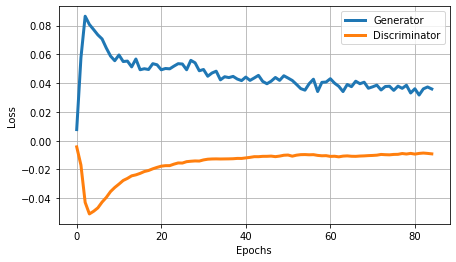

In [144]:
# plot the loss curve
plt.figure(figsize=(7,4))
plt.plot(loss_record['G'], linewidth = 3, label = 'Generator')
plt.plot(loss_record['D'], linewidth = 3, label = 'Discriminator')
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

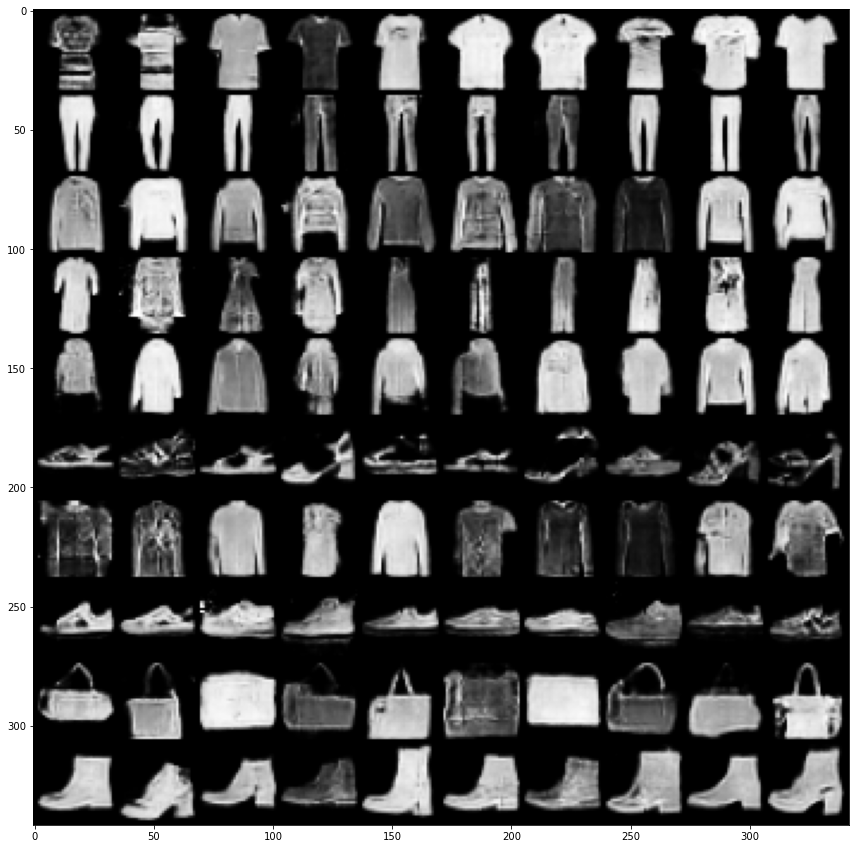

In [152]:
# show some fake image of specific label
G.eval()
z_sample = Variable(torch.randn(100, z_dim, 1, 1)).cuda()
# --------CGAN----------
# z_sample = Variable(torch.randn(50, z_dim)).cuda()
# ----------------------
fix_label = torch.arange(10).repeat(5).cuda()
# label_sample = torch.full((100,), 5).cuda()
# fix_label = one_hot_label[torch.zeros(100).long()+5]
fix_label = one_hot_label[torch.arange(10).repeat(10).sort().values]
f_imgs_sample = (G(z_sample, fix_label).data + 1) / 2.0
# f_imgs_sample = f_imgs_sample.view(-1,1,image_size,image_size)

# Show generated images in the jupyter notebook.
grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


In [146]:
os.makedirs('./Fakes_DCGAN',exist_ok=True)
os.makedirs('./Fakes_WCGAN',exist_ok=True)
os.makedirs('./Fakes_CGAN',exist_ok=True)
os.makedirs('./Reals',exist_ok=True)

In [147]:
G.load_state_dict(torch.load('./model/G.pth'))

<All keys matched successfully>

In [148]:
G.eval()
for label in range(10):
    z_sample = Variable(torch.randn(100, z_dim, 1, 1)).cuda()
    # --------CGAN----------
    # z_sample = Variable(torch.randn(100, z_dim)).cuda()
    # ----------------------
    fix_label = one_hot_label[torch.zeros(100).long() + label]
    # --------CGAN----------
    # fix_label = torch.full((100,), label).cuda()
    # ----------------------
    f_imgs_sample = (G(z_sample, fix_label).data + 1) / 2.0
    # --------CGAN----------
    # f_imgs_sample = f_imgs_sample.view(-1,1,image_size,image_size)
    # ----------------------
    for i in range(100):
        img = f_imgs_sample[i]
        torchvision.utils.save_image(img, fp = f'./Fakes_WCGAN/{label+1}_{i+1}.jpg')
        # --------CGAN----------
        # torchvision.utils.save_image(img, fp = f'./Fakes_CGAN/{label+1}_{i+1}.jpg')
        # ----------------------
        # --------DCCGAN----------
        # torchvision.utils.save_image(img, fp = f'./Fakes_DCGAN/{label+1}_{i+1}.jpg')
        # ----------------------

In [102]:
# save some real image to caculate FID score
labels = [i for i in range(10)]
image_dict = {label:[] for label in labels}
for img, label in dataset:
    if sum([len(v) for v in image_dict.values()]) != 1000:
        if len(image_dict[label]) != 100:
            image_dict[label].append(img)
        else:
            continue
    else:
        break
    
images = [torch.stack(image_dict[i]) for i in image_dict.keys()]
images = torch.cat(images)

for i in range(1000):
    img = images[i]
    torchvision.utils.save_image(img, fp = f'./Reals/{i+1}.jpg')

#### Caculate FID score for fake image from models

In [123]:
# fid score code (fid.py) is from https://github.com/hukkelas/pytorch-frechet-inception-distance/blob/master/fid.py
# git clone first
from fid import load_images, calculate_fid

In [150]:
path1 = './Reals'
path2 = './Fakes_WCGAN'

# --------CGAN----------
# path2 = './Fakes_CGAN'
# ----------------------
# --------DCCGAN----------
# path2 = './Fakes_DCGAN'
# ----------------------

In [69]:
images1 = load_images(path1)
images2 = load_images(path2)
fid_value = calculate_fid(images1, images2, False, 8)
print(fid_value)

Looking for images in ./Reals\*.png
Looking for images in ./Reals\*.jpg
Looking for images in ./Fakes_CGAN\*.png
Looking for images in ./Fakes_CGAN\*.jpg
75.76626697707954


In [135]:
images1 = load_images(path1)
images2 = load_images(path2)
fid_value = calculate_fid(images1, images2, False, 8)
print(fid_value)

Looking for images in ./Reals\*.png
Looking for images in ./Reals\*.jpg
Looking for images in ./Fakes_DCGAN\*.png
Looking for images in ./Fakes_DCGAN\*.jpg
71.11971959730965


In [151]:
images1 = load_images(path1)
images2 = load_images(path2)
fid_value = calculate_fid(images1, images2, False, 8)
print(fid_value)

Looking for images in ./Reals\*.png
Looking for images in ./Reals\*.jpg
Looking for images in ./Fakes_WCGAN\*.png
Looking for images in ./Fakes_WCGAN\*.jpg
51.411930206126954
